<a href="https://colab.research.google.com/github/VellummyilumVinoth/Aspect_based_sentimental_analysis/blob/main/Aspect_auto_categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
!pip install transformers
!pip install --upgrade keras
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import keras.preprocessing.sequence
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import BertForSequenceClassification,BertTokenizer,AdamW
from tqdm import tqdm, trange
from ast import literal_eval

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Load and Preprocess Training Data

Dataset will be tokenized then split into training and validation sets. The validation set will be used to monitor training. For testing a separate test set will be loaded for analysis.

In [5]:
# Step 1: Prepare your dataset
df = pd.read_csv('/content/drive/MyDrive/zidan/aspect_extracted_file.csv')

In [6]:
# Assuming your dataset is stored in X and y variables
df, test_data = train_test_split(df, test_size=0.1)


In [7]:
df

,product_name,review,review_without_emoji,preprocess_text,preprocess_text1,aspects,price,quality,delivery cost,packaging,design,customer service,usability
2941,Amazon Brand - Presto! Flex-a-Size Paper Towel...,I like that they are good quality and I can te...,I like that they are good quality and I can te...,i like that they are good quality and i can te...,"['like', 'good', 'quality', 'tear', 'half', 's...","['quality', 'usability']",0,1,0,0,0,0,1
2239,Wool Dryer Balls - Smart Sheep 6-Pack - XL Pre...,I have to say I was skeptical at first. So I t...,I have to say I was skeptical at first. So I t...,i have to say i was skeptical at first so i te...,"['say', 'skeptical', 'first', 'tested', 'load'...","['price', 'quality', 'design']",1,1,0,0,1,0,0
629,"Hefty Strong Tall Kitchen Trash Bags, Unscente...",Great,Great,great,['great'],[],0,0,0,0,0,0,0
4620,simplehuman Code Q Custom Fit Drawstring Trash...,Loves these bags. They fit perfect,Loves these bags. They fit perfect,loves these bags they fit perfect,"['loves', 'bags', 'fit', 'perfect']",['quality'],0,1,0,0,0,0,0
9647,Toilet Bowl Brush Holder Set: Bathroom Deep Cl...,Does the job and looks nice when not in use.,Does the job and looks nice when not in use.,does the job and looks nice when not in use,"['job', 'looks', 'nice', 'use']","['quality', 'design', 'usability']",0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7095,"Scott 75143 Scott Shop Towels, Blue (3 Rolls, ...",Ordered these a few months ago and they were n...,Ordered these a few months ago and they were n...,ordered these a few months ago and they were n...,"['ordered', 'months', 'ago', 'nice', 'big', 'l...","['quality', 'delivery cost', 'design', 'usabil...",0,1,1,0,1,0,1
3889,100% Compostable Paper 10 inch Bulk {125-Pack]...,We used to buy Chinet plates however the last ...,We used to buy Chinet plates however the last ...,we used to buy chinet plates however the last ...,"['used', 'buy', 'chinet', 'plates', 'however',...","['price', 'quality', 'packaging', 'usability']",1,1,0,1,0,0,1
11047,"Tenergy Solla AAA Rechargeable NiMH Battery, 6...",This was a great deal. Replaced the battery's ...,This was a great deal. Replaced the battery's ...,this was a great deal replaced the batterys in...,"['great', 'deal', 'replaced', 'batterys', 'sol...","['price', 'quality']",1,1,0,0,0,0,0
8265,Prestee 300 Clear Plastic Spoons Bulk | Heavy-...,These are durable plastic spoons which don't t...,These are durable plastic spoons which don't t...,these are durable plastic spoons which dont ta...,"['durable', 'plastic', 'spoons', 'dont', 'take...","['price', 'quality', 'usability']",1,1,0,0,0,0,1


In [8]:
columns_to_drop = ['product_name', 'preprocess_text','review_without_emoji', 'aspects', 'preprocess_text1']
df.drop(columns_to_drop, axis=1, inplace=True)

In [9]:
df.head()

,review,price,quality,delivery cost,packaging,design,customer service,usability
2941,I like that they are good quality and I can te...,0,1,0,0,0,0,1
2239,I have to say I was skeptical at first. So I t...,1,1,0,0,1,0,0
629,Great,0,0,0,0,0,0,0
4620,Loves these bags. They fit perfect,0,1,0,0,0,0,0
9647,Does the job and looks nice when not in use.,0,1,0,0,1,0,1


In [10]:
print('Unique comments: ', df.review.nunique() == df.shape[0])
print('Null values: ', df.isnull().values.any())

Unique comments:  False
Null values:  False


In [11]:
print('average sentence length: ', df.review.str.split().str.len().mean())
print('stdev sentence length: ', df.review.str.split().str.len().std())

average sentence length:  46.48718721736509
stdev sentence length:  87.33645109624881


In [12]:
cols = df.columns
label_cols = list(cols[1:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['price', 'quality', 'delivery cost', 'packaging', 'design', 'customer service', 'usability']


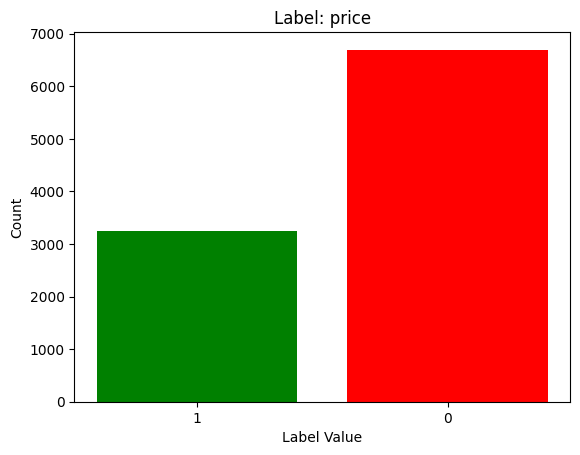

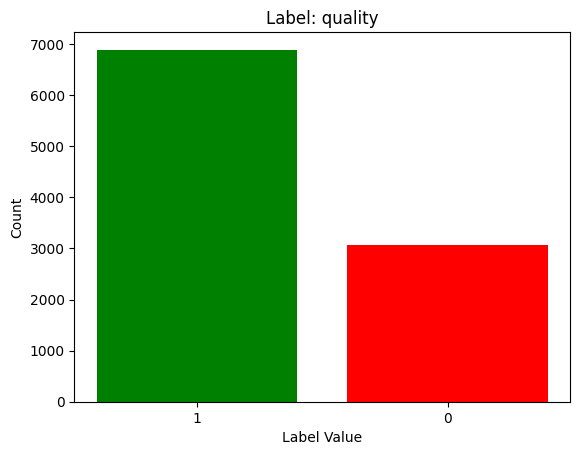

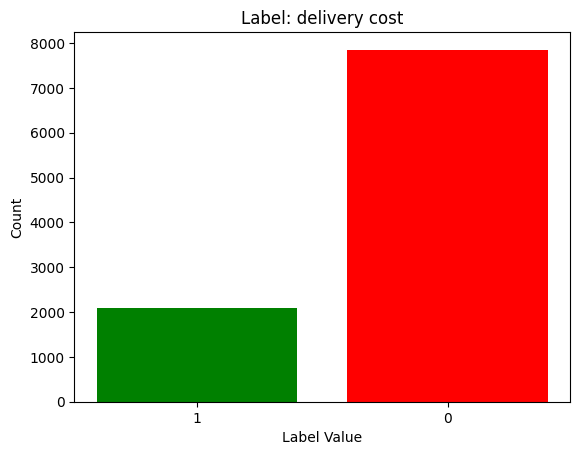

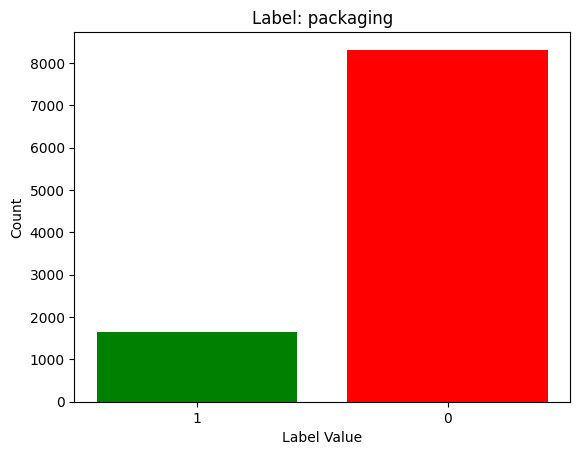

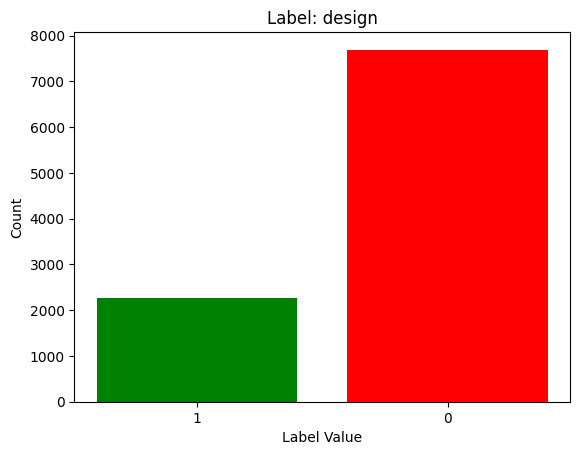

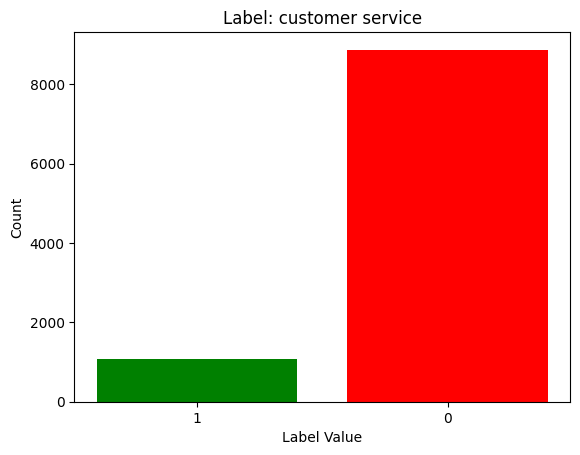

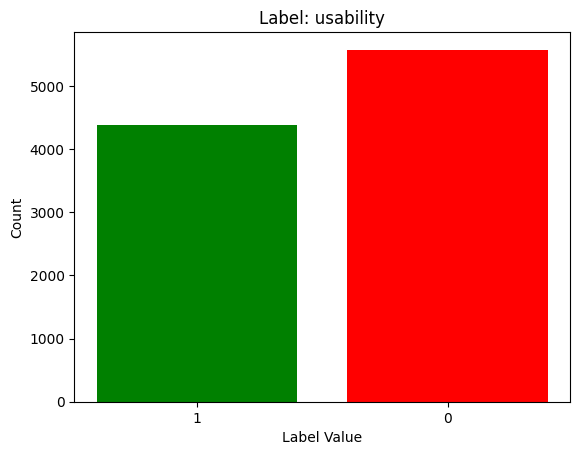

In [13]:
import matplotlib.pyplot as plt
# Count of 1 per label
label_counts_1 = df[label_cols].sum()

# Count of 0 per label
label_counts_0 = df[label_cols].eq(0).sum()

# Create separate graphs for each aspect label
colors_1 = ['green' for _ in range(num_labels)]  # Color for 1 values
colors_0 = ['red' for _ in range(num_labels)]    # Color for 0 values

for i, aspect_label in enumerate(label_cols):
    fig, ax = plt.subplots()
    ax.bar(['1', '0'], [label_counts_1[i], label_counts_0[i]], color=[colors_1[i], colors_0[i]])
    ax.set_xlabel('Label Value')
    ax.set_ylabel('Count')
    ax.set_title(f'Label: {aspect_label}')
    plt.show()

In [14]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle rows

In [15]:
df['labels'] = list(df[label_cols].values)
df.head()

,review,price,quality,delivery cost,packaging,design,customer service,usability,labels
0,I searched for coated paper plates. These came...,0,1,0,0,0,0,1,"[0, 1, 0, 0, 0, 0, 1]"
1,Good value pack. So far happy with the rollers...,1,1,0,0,1,1,1,"[1, 1, 0, 0, 1, 1, 1]"
2,"I only use hefty trash bags, and I saw these o...",1,1,0,1,0,0,1,"[1, 1, 0, 1, 0, 0, 1]"
3,The sole purpose of storage bags is to keep th...,0,0,0,1,0,0,1,"[0, 0, 0, 1, 0, 0, 1]"
4,These are very nice rubber gloves. I like that...,0,1,0,1,0,0,1,"[0, 1, 0, 1, 0, 0, 1]"


In [16]:
labels = list(df.labels.values)
comments = list(df.review.values)

In [17]:
max_length = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer
encodings = tokenizer.batch_encode_plus(comments,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [18]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [19]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df.labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [6966, 4514, 4110, 3586, 2338]


In [20]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

Be sure to handle all classes during validation using "stratify" during train/validation split:

In [21]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=2020, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

<ipython-input-21-8effe635eb5d>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train_labels = torch.tensor(train_labels)


In [22]:
# Select a batch size for training. We will use 32 here to avoid memory issues.
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [23]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

## Load Model & Set Params

In [24]:
# Load model, the pretrained model will include a single linear classification layer on top for classification.
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Setting custom optimization parameters for the AdamW optimizer https://huggingface.co/transformers/main_classes/optimizer_schedules.html

In [25]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [26]:
optimizer = AdamW(optimizer_grouped_parameters,lr=4e-5,correct_bias=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train Model

In [27]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss()
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss()
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.3427830381585019


Epoch:  33%|███▎      | 1/3 [03:23<06:46, 203.21s/it]

F1 Validation Accuracy:  91.62303664921467
Flat Validation Accuracy:  73.76884422110552
Train loss: 0.10780653402741466


Epoch:  67%|██████▋   | 2/3 [06:45<03:22, 202.62s/it]

F1 Validation Accuracy:  95.80698055750761
Flat Validation Accuracy:  87.8391959798995
Train loss: 0.0610610209072807


Epoch: 100%|██████████| 3/3 [10:07<00:00, 202.64s/it]

F1 Validation Accuracy:  96.31873252562907
Flat Validation Accuracy:  89.84924623115577


In [28]:
import os

output_dir = os.path.expanduser('/content/drive/MyDrive/zidan/finetuned_bert')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print('Saved')

Saved


## Load and Preprocess Test Data

In [29]:
test_data.head()

,product_name,review,review_without_emoji,preprocess_text,preprocess_text1,aspects,price,quality,delivery cost,packaging,design,customer service,usability
7791,Duracell 303/357/76 Silver Oxide Button Batter...,Not too sure how to review a battery LOL Onl...,Not too sure how to review a battery LOL Onl...,not too sure how to review a battery lol onl...,"['sure', 'review', 'battery', 'lol', 'using', ...",['quality'],0,1,0,0,0,0,0
4793,Toilet Seat Covers Paper Flushable (50 Pack) -...,These are great! I purchased them for a family...,These are great! I purchased them for a family...,these are great i purchased them for a family ...,"['great', 'purchased', 'family', 'road', 'trip...","['price', 'packaging', 'design']",1,0,0,1,1,0,0
8521,6Pcs Scourer Steel Wool Scrubber - Steel Wool ...,The product arrived very quickly. The size is...,The product arrived very quickly. The size is...,the product arrived very quickly the size is ...,"['product', 'arrived', 'quickly', 'size', 'per...","['quality', 'delivery cost', 'customer service...",0,1,1,0,0,1,1
8203,"Amazon Basics Heavy-Duty Broom, Blue and White",Best broom ever..loved having to put it 2gethe...,Best broom ever..loved having to put it 2gethe...,best broom everloved having to put it 2getherw...,"['best', 'broom', 'everloved', 'put', '2gether...",['quality'],0,1,0,0,0,0,0
4433,"Kleenex On-The-Go Facial Tissues, 10 Tissue - ...",They were nicely packaged Kleenex,They were nicely packaged Kleenex,they were nicely packaged kleenex,"['nicely', 'packaged', 'kleenex']",['packaging'],0,0,0,1,0,0,0


In [30]:
columns_to_drop = ['product_name', 'aspects', 'review','review_without_emoji','preprocess_text1']
test_data.drop(columns_to_drop, axis=1, inplace=True)

test_label_cols = list(test_data.columns[1:])
print('Null values:', test_data.isnull().values.any())  # Should not be any null sentences or labels
print('Same columns between train and test:', label_cols == test_label_cols)  # Columns should be the same

test_data[test_label_cols] = -1  # Set label column values to -1

Null values: False
Same columns between train and test: True


In [31]:
test_data = test_data.replace(-1, 0)  # Change -1 to 0 in the entire DataFrame

test_data = test_data[~test_data[test_label_cols].eq(-1).any(axis=1)]  # Remove irrelevant rows/comments with -1 values
test_data['labels'] = list(test_data[test_label_cols].values)

In [32]:
# Gathering input data
test_labels = list(test_data.labels.values)
test_comments = list(test_data.preprocess_text.values)

In [33]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [34]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

## Prediction and Metics

In [35]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Variables to gather full output
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(validation_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

# Calculate Accuracy
threshold = 0.50
pred_bools = [pl>threshold for pl in pred_labels]
true_bools = [tl==1 for tl in true_labels]
f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
flat_accuracy = accuracy_score(true_bools, pred_bools)*100

print('Test F1 Accuracy: ', val_f1_accuracy)
print('Test Flat Accuracy: ', val_flat_accuracy)

clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report

Test F1 Accuracy:  96.31873252562907
Test Flat Accuracy:  89.84924623115577


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Output Dataframe

In [36]:
idx2label = dict(zip(range(7),label_cols))
print(idx2label)

{0: 'price', 1: 'quality', 2: 'delivery cost', 3: 'packaging', 4: 'design', 5: 'customer service', 6: 'usability'}


In [37]:
# Getting indices of where boolean one hot vector true_bools is True so we can use idx2label to gather label names
true_label_idxs, pred_label_idxs=[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools:
  pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

In [38]:
# Gathering vectors of label names using idx2label
true_label_texts, pred_label_texts = [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in pred_label_idxs:
  if vals:
    pred_label_texts.append([idx2label[val] for val in vals])
  else:
    pred_label_texts.append(vals)

In [39]:
# Decoding input ids to reviews
reviews = [tokenizer.decode(text,skip_special_tokens=True,clean_up_tokenization_spaces=False) for text in tokenized_texts]

In [40]:
# Converting lists to df
comparisons_df = pd.DataFrame({'reviews': reviews,'pred_labels':pred_label_texts})
comparisons_df.to_csv('/content/drive/MyDrive/zidan/test_predictions.csv')
comparisons_df


,reviews,pred_labels
0,easy to use,"[quality, design, usability]"
1,just click buy and you ' ll be glad you did . ...,"[price, design]"
2,price is great compared to say duracell or ene...,"[price, quality, delivery cost, usability]"
3,great value and well made . will order again o...,"[price, quality, packaging]"
4,we have a lot of animals so this is great for ...,"[price, delivery cost, customer service]"
...,...,...
990,"love these brushes , exactly what i was lookin...","[quality, design]"
991,these bowls are multi - purpose food serving d...,"[quality, delivery cost, usability]"
992,"i have tried many hacks to clean my bottles , ...","[quality, packaging, design]"
993,i bought these disposable gloves to wear while...,"[quality, delivery cost, customer service, usa..."
